## Emojify
5th course - Sequence Model - Week 2

Rather than writing:

"Congratulations on the promotion! Let's get coffee and talk. Love you!"

The emojifier can automatically turn this into:

"Congratulations on the promotion! 👍 Let's get coffee and talk. ☕️ Love you! ❤️"


### 1. Baseline model: Emojifier-V1 - using word embeddings
Let's start by building a simple baseline classifier.

You have a tiny dataset (X, Y) where:
* X contains 127 sentences (strings)
* Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence

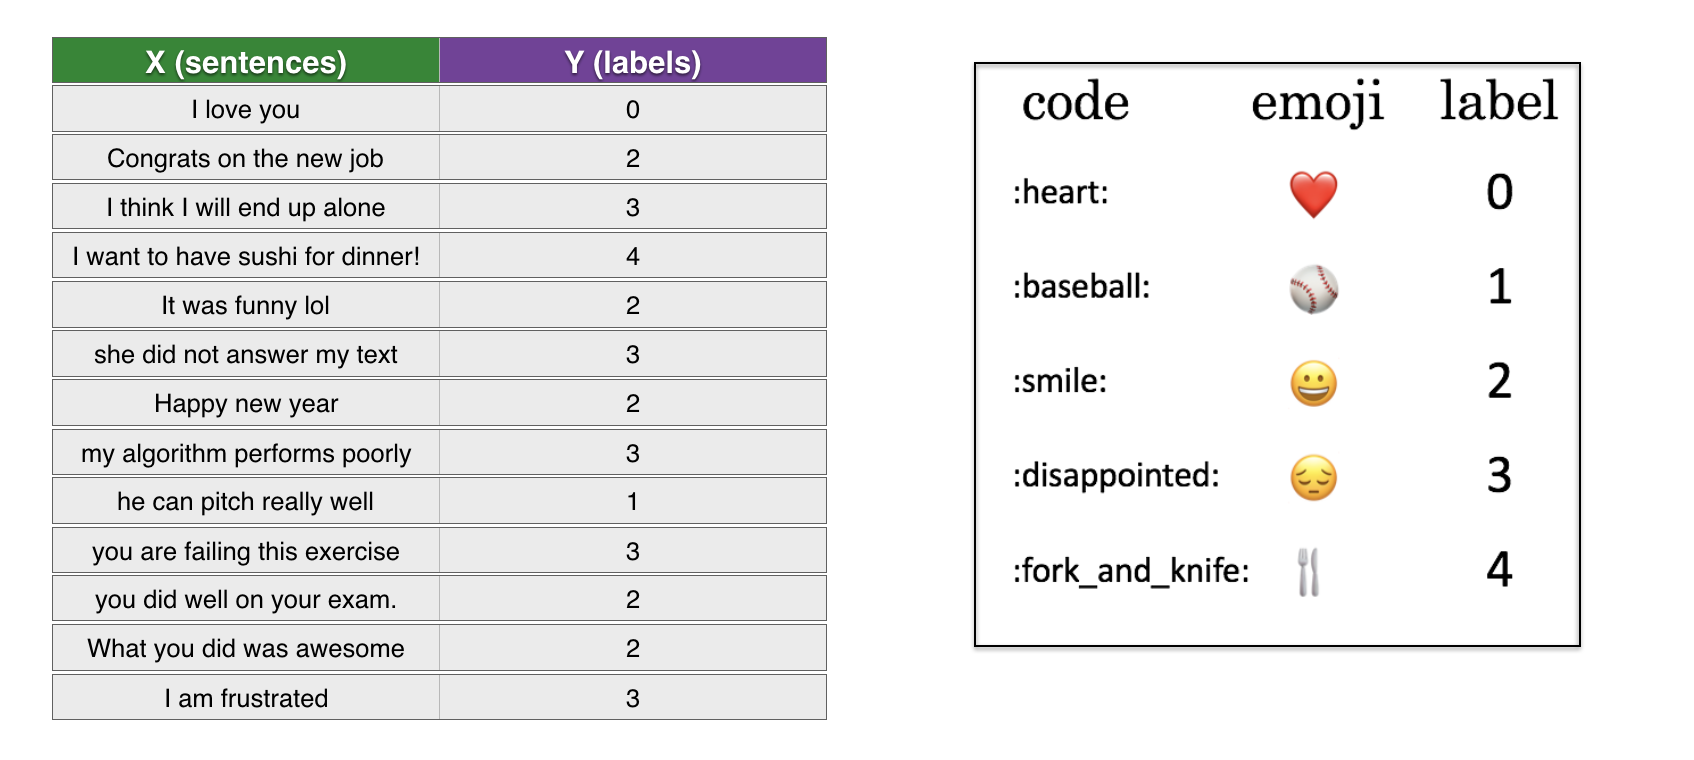

In [2]:
import warnings
warnings.filterwarnings('error', category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import emoji
from sklearn.metrics import confusion_matrix

In [3]:
# Utils functions
def read_csv(filename='emojify_data.csv'):
    phrase = []
    emoji = []   
    with open(filename) as f:
        csv_reader = csv.reader(f)
        for row in csv_reader:
            phrase.append(row[0])
            emoji.append(row[1])
    X = np.asarray(phrase)
    y = np.asarray(emoji, dtype=int)
    return X, y

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        words_to_index = {}
        index_to_words = {}
        i = 1
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i += 1
    return words_to_index, index_to_words, word_to_vec_map

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

emoji_dictionary = {#"0": ":red_heart:",    # :heart: prints a black instead of red heart depending on the font
                    "0": "\u2764\ufe0f",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], language='alias')

def print_predictions(X, pred):
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i][0])))

def plot_confusion_matrix(y_actu, y_pred, cmap=plt.cm.gray_r):
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(-1).astype(int), rownames=['Actual'], colnames=['Predicted'], 
                               margins=True)
    #df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    plt.matshow(df_confusion, cmap='Blues')
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()

def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of the model over the given set
    Arguments:
    X: input data containing sentences, numpy array of shape (m, None)
    Y: labels, containing indices of the label emoji, numpy array of shape (m, 1)
    Returns:
    pred: numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    any_word = list(word_to_vec_map.keys())[0]
    n_h = word_to_vec_map[any_word].shape[0]    # number of classes

    # loop over the training examples
    for j in range(m):
        # split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()

        # average words' vectors
        avg = np.zeros((n_h, ))
        count = 0
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
                count += 1
        if count > 0:
            avg = avg / count

        # forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)

    print('Accuracy: ' + str(np.mean((pred[:] == Y.reshape(Y.shape[0], 1)[:]))))
    return pred

In [16]:
emoji.emojize("python is cold :panda::cold_face:")

'python is cold 🐼🥶'

In [4]:
X_train, y_train = read_csv('train_emoji.csv')
X_test, y_test = read_csv('tesss.csv')

In [35]:
X_train.shape

(132,)

In [36]:
X_test.shape

(56,)

In [5]:
maxLen = len(max(X_train, key=len).split())
maxLen

10

In [40]:
for i in range(10):
    print(X_train[i], label_to_emoji(y_train[i]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


### Overview of the Emojifier-V1
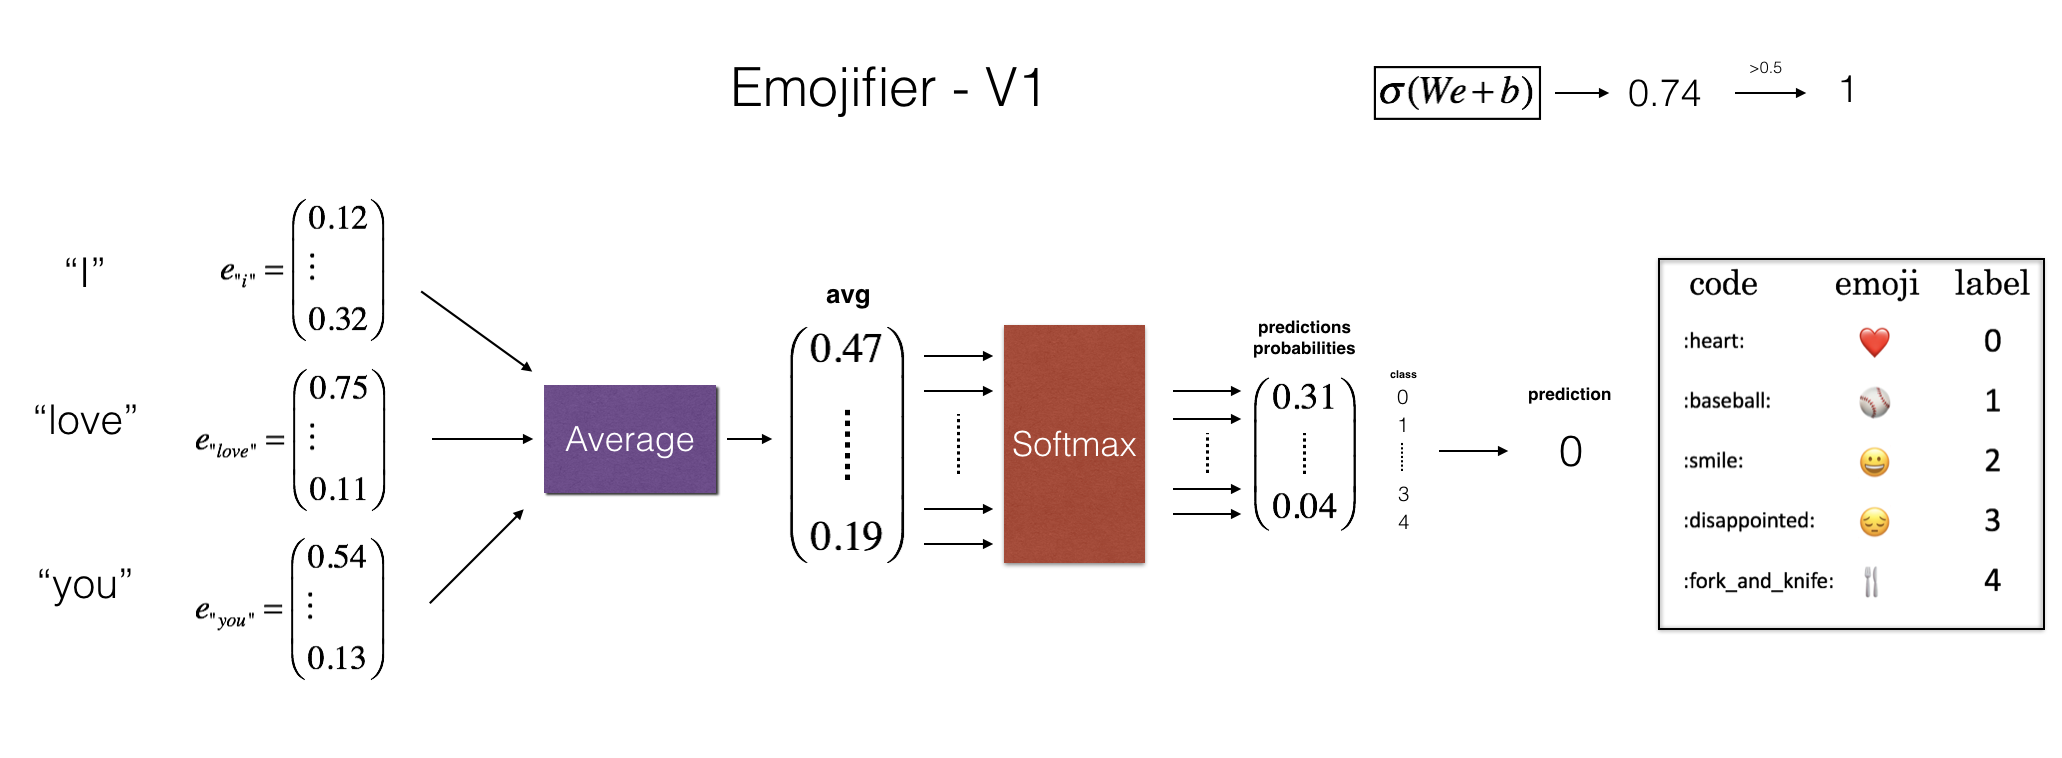

**Inputs and outputs**
* The input of the model is a string corresponding to a sentence (e.g. "I love you)
* The output will be a probability vector of shape (1, 5), (there are 5 emojis to choose from)
* The (1, 5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability

**One-hot encoding**
* To get our labels into a format suitable for training a softmax classifier, lets convert $Y$ from its current shape (m, ) into a "one-hot representation" (m, 5)
   * Each row is a one-hot vector giving the label of one example.
   * Here, Y_oh stands for "Y-one-hot" in the variable names Y_oh_train and Y_oh_test:

In [6]:
Y_oh_train = convert_to_one_hot(y_train, C=5)
Y_oh_test = convert_to_one_hot(y_test, C=5)

In [52]:
Y_oh_test.shape

(56, 5)

In [7]:
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [62]:
word_to_vec_map['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

In [63]:
len(word_to_vec_map)

400000

In [65]:
words_to_index['the']

357266

In [68]:
index_to_words[357266]

'the'

In [8]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence into a list of words, exract the GloVe representation of each word,
    and averages its value into a single vector encoding the meaning of the sentence
    """
    words = sentence.lower().split()
    avg = np.zeros((50, ))
    for w in words:
        avg += word_to_vec_map[w]
    avg /= len(words)
    return avg

In [82]:
avg = sentence_to_avg('Morrocan couscous is my favorite dish', word_to_vec_map)
avg

array([-0.008005  ,  0.56370833, -0.50427333,  0.258865  ,  0.55131103,
        0.03104983, -0.21013718,  0.16893933, -0.09590267,  0.141784  ,
       -0.15708967,  0.18525867,  0.6495785 ,  0.38371117,  0.21102167,
        0.11301667,  0.02613967,  0.26037767,  0.05820667, -0.01578167,
       -0.12078833, -0.02471267,  0.4128455 ,  0.5152061 ,  0.38756167,
       -0.898661  , -0.535145  ,  0.33501167,  0.68806933, -0.2156265 ,
        1.797155  ,  0.10476933, -0.36775333,  0.750785  ,  0.10282583,
        0.348925  , -0.27262833,  0.66768   , -0.10706167, -0.283635  ,
        0.59580117,  0.28747333, -0.3366635 ,  0.23393817,  0.34349183,
        0.178405  ,  0.1166155 , -0.076433  ,  0.1445417 ,  0.09808667])

### Model
We now have all the pieces to finish implementing the model() function. After using sentence_to_avg() we need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

The equations we need to implement in the forward pass and to compute the cross-entropy cost are below:
$$z^{(i)} = W \cdot avg^{(i)} + b$$
$$a^{(i)} = softmax(z^{(i)})$$
$$\mathcal{L}^{(i)} = -\sum^{n_y-1}_{k=0} Y^{(i)}_{oh, k} * log(a^{(i)}_k)$$

**Note**: It is possible to come up with a more efficient vectorized implementation. For now, let's use nested for loops to better understand the algorithm, and for easier debugging.

In [9]:
def model(X, Y, word_to_vec_map, learning_rate=0.01, n_iters=400):
    """
    Model to train word vector representation in numpy
    Returns:
    pred: vector of predictions, numpy array of shape(m, 1)
    W: weight matrix of the softmax layer, of shape (n_y, n_h), 
       where n_y: number of classes, n_h: dimensions of the GloVe vectors
    b: bias of the softmax layer, of shape(n_y, )
    """
    np.random.seed(1)
    m = Y.shape[0]
    n_y = 5
    n_h = 50

    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)   # initialize parameters using Xavier initialization
    b = np.zeros((n_y, ))

    Y_oh = convert_to_one_hot(Y, C=n_y)

    # optimization loop
    for t in range(n_iters):
        for i in range(m):
            avg = sentence_to_avg(X[i], word_to_vec_map)
            z = np.dot(W, avg) + b
            a = softmax(z)
            cost = -np.sum(Y_oh[i] * np.log(a))
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y, 1), avg.reshape(1, n_h))
            db = dz
            W = W - learning_rate * dW
            b = b - learning_rate * db

        if t % 100 == 0:
            print('Epoch: '+ str(t) + ' --- cost = ' + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)     # will print out accuracy
            
    return pred, W, b

In [10]:
pred, W, b = model(X_train, y_train, word_to_vec_map)

Epoch: 0 --- cost = 1.9520498812810072
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014807
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697


In [91]:
pred[:3]

array([[3.],
       [2.],
       [3.]])

In [92]:
print('Training set:')
pred_train = predict(X_train, y_train, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273


In [93]:
print('Test set:')
pred_test = predict(X_test, y_test, W, b, word_to_vec_map)

Test set:
Accuracy: 0.8571428571428571


* Random guessing would have had 20% accuracy given that there are 5 classes (1/5 = 20%)
* This is pretty good performance after training on only 132 examples

**The model matches emojis to relevant words**

In the training set, the algorithm saw the sentence: "I love you" with the label ❤️.

* the word "adore" does not appear in the training set, nonetheless, lets see what happens if we write "I adore you."

In [107]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])

Y_my_labels = np.array([[0], [0], [2], [1], [4], [3]])

preds = predict(X_my_sentences, Y_my_labels, W, b, word_to_vec_map)

print_predictions(X_my_sentences, preds)

Accuracy: 0.8333333333333334
i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


* adore has a similar embedding as love, the algorithm has generalized correctly even to a word it has never seen before
* Words such as heart, dear, beloved and adore have embedding vectors similar to love

**Word ordering isn't considered in this model**
* the model doesn't get the following sentence correct: "not feeling happy"
* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy"
 
**Confusion matrix**
* Printing the confusion matrix can also help understand which classes are more difficult for our model
* A confusion matrix shows how often an example whose label is one class ("actual") is mislabeled by the algorithm with a different class ("predicted")

In [127]:
pd.crosstab(y_test, pred_test.reshape(-1).astype(int), rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,All
Actual,,,,,,
0,6,0,0,1,0,7
1,0,8,0,0,0,8
2,2,0,16,0,0,18
3,1,1,2,12,0,16
4,0,0,1,0,6,7
All,9,9,19,13,6,56


         ❤️     ⚾    😄     😞     🍴


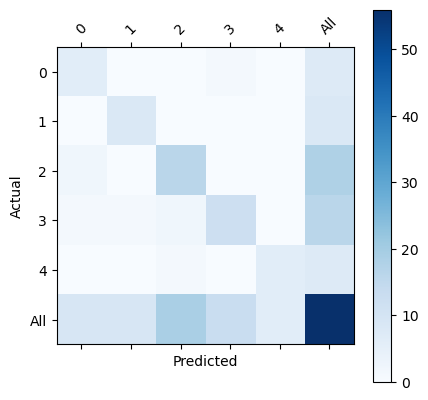

In [185]:
print('         '+ label_to_emoji(0)+ '     ' + label_to_emoji(1) + '    ' +  label_to_emoji(2) + '     ' + label_to_emoji(3) + '     ' + label_to_emoji(4))
plot_confusion_matrix(y_test, pred_test)

**Take Away**

* Even with a 132 training examples, you can get a reasonably good model for Emojifying
   * This is due to the generalization power, word vectors gives you
* Emojify-V1 will perform poorly on sentences such as "This movie is not good and not enjoyable"
   * It doesn't understand combinations of words
   * It just averages all the words' embedding vectors together, without considering the ordering of words
     
We will build a better algorithm next ! (see emojify2)

In [186]:
X_my_sentences = np.array(["i am not happy", "i am sad", "this movie is not good", "this movie is bad", "not happy", "bad"])

Y_my_labels = np.array([[3], [3], [3], [3], [3], [3]])

preds = predict(X_my_sentences, Y_my_labels, W, b, word_to_vec_map)

print_predictions(X_my_sentences, preds)

Accuracy: 0.5
i am not happy 😞
i am sad 😞
this movie is not good 😄
this movie is bad 😄
not happy ❤️
bad 😞
